In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [2]:
import cartopy.feature
import matplotlib.path as mpath
import cmasher as cmr

# Define a function to make figures only showing the Southern Ocean between south of 40S
def axku(ax1):
    ax1.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)

In [3]:
# Define moving average to smooth out the limitation
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [4]:
orcagrid=xr.open_dataset('ORCA2.0.full_grid.nc')

In [5]:
flimfile=['FELIM_mnclim.nc','FELIM_antentok.nc','FELIM_asmalltok.nc','FELIM_feplig.nc'] # Output for Fe limitation
mlimfile=['MNLIM_mnclim.nc','MNLIM_antentok.nc','MNLIM_asmalltok.nc','MNLIM_feplig.nc'] # Output for Mn limitation
phyfiles=['ALLPHY_mnclim.nc','ALLPHY_antentok.nc','ALLPHY_asmalltok.nc','ALLPHY_feplig.nc'] # Phytoplankton C biomass

flin=[]
flid=[]
flip=[]
totfli=[]

mlin=[]
mlid=[]
mlip=[]
totmli=[]

fphyns=[]
fphyps=[]
fphyds=[]

for f, flim in enumerate(flimfile):
    # Open files
    flm= xr.open_dataset(flim)
    mlm= xr.open_dataset(mlimfile[f])
    phyfile= xr.open_dataset(phyfiles[f])

    print(f)
    
    # Fe limitation -> only compute south of 40S
    felimn= flm['LNFe'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    felimd= flm['LDFe'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    felimp= flm['LPFe'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    
    flin.append(felimn)
    flid.append(felimd)
    flip.append(felimp)
    
    #Mn limitation
    mnlimn= mlm['MNLIMN'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    mnlimd= mlm['MNLIMD'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    mnlimp= mlm['MNLIMP'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    
    mlin.append(mnlimn)
    mlid.append(mnlimd)
    mlip.append(mnlimp)
    
    #Phytoplankton C biomass concentration
    phy= phyfile['ALLPHY'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    phyn= phyfile['PHY'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    phyd= phyfile['PHY2'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    phynp= phyfile['PIC'].sel(deptht=4.999938e+00).where(flm['nav_lat']<-40).compute()
    
    fphyn= phyn/phy
    fphyd= phyd/phy
    fphyp= phynp/phy
    
    fphyns.append(fphyn)
    fphyds.append(fphyd)
    fphyps.append(fphyp)
    
    # Calculate total limitation
    totflim= (felimn*fphyn)+(felimd*fphyd)+(felimp*fphyp)
    totmlim= (mnlimn*fphyn)+(mnlimd*fphyd)+(mnlimp*fphyp)
    
    totfli.append(totflim)
    totmli.append(totmlim)

    

0
1
2
3


In [6]:
flimareas=[]
mlimareas=[]

mngroup=[]
fegroup=[]

grfe=[]
grmn=[]

for f, tf in enumerate(totfli):
    
    # Find the most limited month every year:
    # Fe
    totfelimax= tf.groupby('time_counter.year').min()
    totmnlimax= totmli[f].groupby('time_counter.year').min()
    
    fenlimax= flin[f].groupby('time_counter.year').min() #Nano
    feplimax= flip[f].groupby('time_counter.year').min() #Pico
    fedlimax= flid[f].groupby('time_counter.year').min() #Diatoms
    
    groupfe=[fedlimax,fenlimax,feplimax,totfelimax]
    grfe.append(groupfe)
    
    # Mn
    mnnlimax= mlin[f].groupby('time_counter.year').min()
    mnplimax= mlip[f].groupby('time_counter.year').min()
    mndlimax= mlid[f].groupby('time_counter.year').min()
    
    groupmn=[mndlimax,mnnlimax,mnplimax,totmnlimax]
    grmn.append(groupmn)
    
    ###########################################################
    
    mngroups=[]
    fegroups=[]
    phytotypes=['diat','nano','pico']
    
    for g in range(len(groupmn)):
        # Find areas where Mn is more limited than Fe
        mnpmore= groupfe[g].where((groupmn[g]<groupfe[g]) & (groupmn[g] > 0))
        # Find areas where Fe is more limited than Mn
        fepmore= groupfe[g].where((groupfe[g]<groupmn[g]) & (groupfe[g] > 0))
        
        pmlimarea=[]
        pflimarea=[]
        
        for p in range(len(fepmore)):
            # Calculatethe area in m2
            of_areafe= orcagrid['area'].where((fepmore[p] < 1) & (totfelimax['nav_lat']<-40))
            of_areamn= orcagrid['area'].where((mnpmore[p] < 1) & (totfelimax['nav_lat']<-40))
            # Convert to Km2
            of_areafe1= of_areafe.sum()*1e-6
            of_areamn1= of_areamn.sum()*1e-6
        
            pmlimarea.append(of_areamn1)
            pflimarea.append(of_areafe1)
            
        mngroups.append(np.array(pmlimarea))
        fegroups.append(np.array(pflimarea))
        
    mngroup.append(mngroups)
    fegroup.append(fegroups)
    #########################################################   
    
    # Find areas where Mn is more limited than Fe, but for total Mn lim
    mnmore= totfelimax.where(totmnlimax<totfelimax)
    # Find areas where Fe is more limited than Mn, but for total Fe lim
    femore= totfelimax.where(totfelimax<totmnlimax)

    mlimarea=[]
    flimarea=[]
    
    # The same fo Mn
    for l in range(len(mnmore)):
        of_areafe= orcagrid['area'].where((femore[l] < 1) & (totfelimax['nav_lat']<-40))
        of_areamn= orcagrid['area'].where((mnmore[l] < 1) & (totfelimax['nav_lat']<-40))
        
        of_areafe1= of_areafe.sum()*1e-6
        of_areamn1= of_areamn.sum()*1e-6
        
        mlimarea.append(of_areamn1)
        flimarea.append(of_areafe1)
        
    mlimareas.append(np.array(mlimarea)) 
    flimareas.append(np.array(flimarea))
    
        

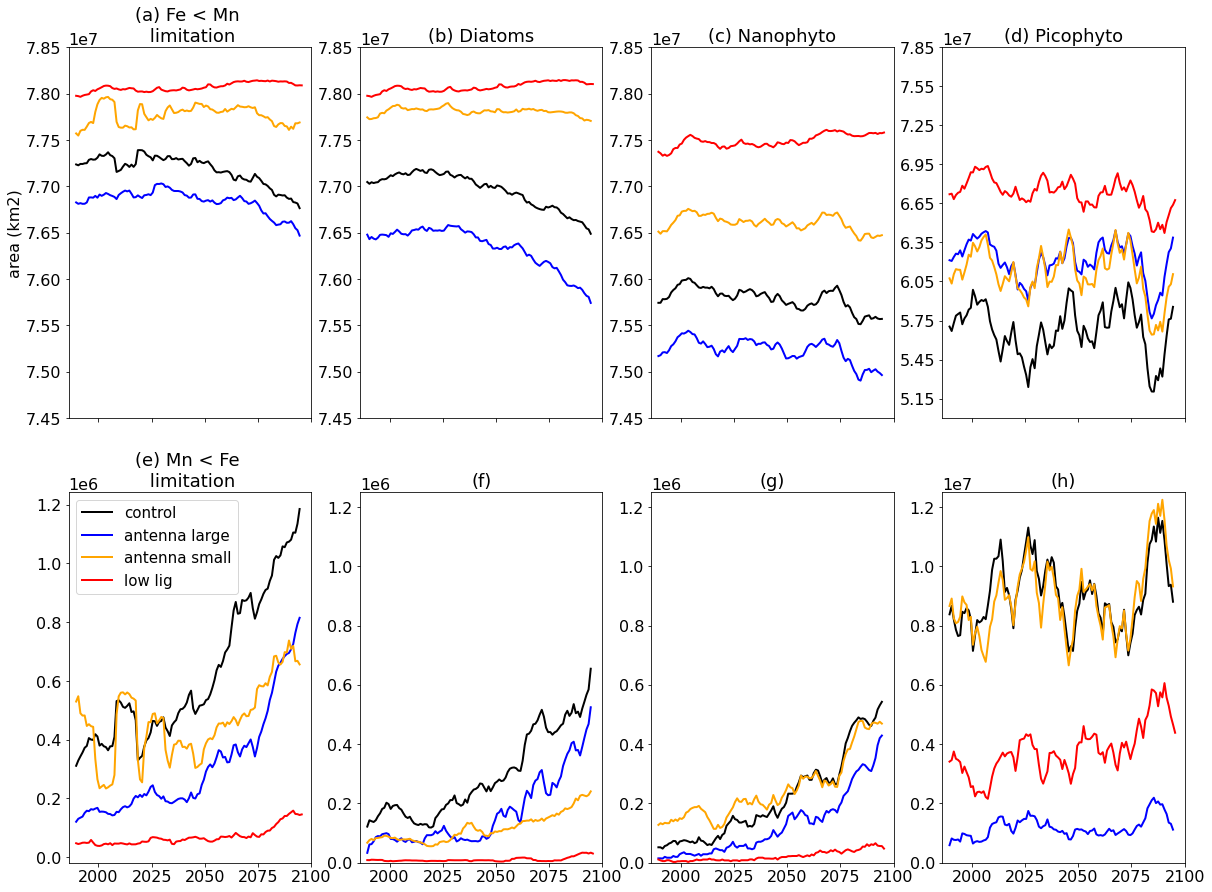

In [9]:
# Plotting Figure 1

fig, axs = plt.subplots(2, 4, sharex=True,figsize=(20,15))
fig.patch.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 15})


expt=['control','antenna large','antenna small','low lig']

mdiffas=[]
fdiffas=[]
coloro=['black','blue','orange','red']
flimareas10s=[]
mlimareas10s=[]

# Plot only the total Mn and Fe limitation #
for m in range(len(mlimareas)):
    
    yrlen=len(mlimareas[m])
    yrf=[]
    for f in range(yrlen):
        s=str(totmnlimax.coords['year'].values[f])[:4]
        inte=int(s)
        yrf.append(inte)


    yr10= moving_average(yrf, n=10)
    
    # Smoothing by averaging over 10 years
    mlimareas10= moving_average(mlimareas[m], n=10)
    flimareas10= moving_average(flimareas[m], n=10)
    mlimareas10s.append(mlimareas10)
    flimareas10s.append(flimareas10)

    axs[1,0].plot(yr10, mlimareas10, label=expt[m], linewidth=2, color=coloro[m])
    axs[0,0].plot(yr10, flimareas10, linewidth=2, color=coloro[m])
    axs[1,0].legend(loc='best')
    axs[1,0].set_xlim(1986,2100)
axs[1,0].set_title('(e) Mn < Fe \n limitation')
axs[0,0].set_title('(a) Fe < Mn \n limitation')
axs[0,0].set_ylabel('area (km2)')
axs[0,0].set_xlim([1986,2100])
axs[1,0].set_xlim([1986,2100])


#
ccmphy=[]
refmphy=[]

ccfphy=[]
reffphy=[]

phytotypes=['(b) Diatoms','(c) Nanophyto', '(d) Picophyto']
letters=['(f)', '(g)','(h)','(i)']

# Plot Mn and Fe limitation for Diatoms, nano and pico
for m in range(len(mngroup)):
    mng= mngroup[m]
    feg= fegroup[m]
    
    awalm=[]
    awalf=[]
    
    for mn in range(len(phytotypes)):
        mngs= mng[mn]
        fegs= feg[mn]
        
        yrlen=len(mng[mn])
        yrf=[]
        for f in range(yrlen):
            s=str(totmnlimax.coords['year'].values[f])[:4]
            inte=int(s)
            yrf.append(inte)


        yr10= moving_average(yrf, n=10)
        
        awalmlim= np.mean(mngs[0:20])
        awalflim= np.mean(fegs[0:20])
        
        awalm.append(awalmlim)
        awalf.append(awalflim)
        
        mngs10= moving_average(mngs, n=10)
        fegs10= moving_average(fegs, n=10)
        axs[1,(mn+1)].plot(yr10,mngs10, linewidth=2, color=coloro[m])
        axs[0,(mn+1)].plot(yr10,fegs10, linewidth=2, color=coloro[m])
        if phytotypes[mn]=='(b) Diatoms':
            axs[1,(mn+1)].set_ylim(0, 7.5e5)
        elif phytotypes[mn]=='(c) Nanophyto':
            axs[1,(mn+1)].set_ylim(0, 7.5e5)

        axs[0,(mn)].set_ylim(7.45e7, 7.85e7)
        axs[1,(mn+1)].set_ylim(0, 1.25e6)
        if mn == 2:
            axs[1,(mn+1)].set_ylim(0, 1.25e7)
            axs[0,(mn+1)].set_ylim(5.0e7, 7.85e7)
            axs[0,(mn+1)].set_yticks([5.15e7, 5.45e7, 5.75e7, 6.05e7, 6.35e7, 6.65e7, 6.95e7, 7.25e7, 7.55e7, 7.85e7])
        axs[0,(mn+1)].set_title(phytotypes[mn])
        axs[1,(mn+1)].set_title(letters[mn])

        axs[1,(mn+1)].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        

        
mdiffs=[]
fdiffs=[]

for m in range(len(mngroup)):
    mng= mngroup[m]
    feg= fegroup[m]
    
    awalm=[]
    awalf=[]
    
    diffm=[]
    difff=[]
    
    for mn in range(len(mng)):
        mngs= mng[mn]
        fegs= feg[mn]
        
        # Calculate Reference period average
        awalmlim= np.mean(mngs[0:21])
        awalflim= np.mean(fegs[0:21])
        # Calculate climate change period average
        akhimlim= np.mean(mngs[104:115])
        akhiflim= np.mean(fegs[104:115])

        awalm.append(awalmlim)
        awalf.append(awalflim)
        
        # Append the difference between climate change and reference
        diffm.append(akhimlim-awalmlim)
        difff.append(akhiflim-awalflim)
        
        
    mdiffas.append(awalm)
    fdiffas.append(awalf)
    
    mdiffs.append(diffm)
    fdiffs.append(difff)
    
# Save figure    
fig.savefig('deficiency_timeseries2.png',dpi=200)

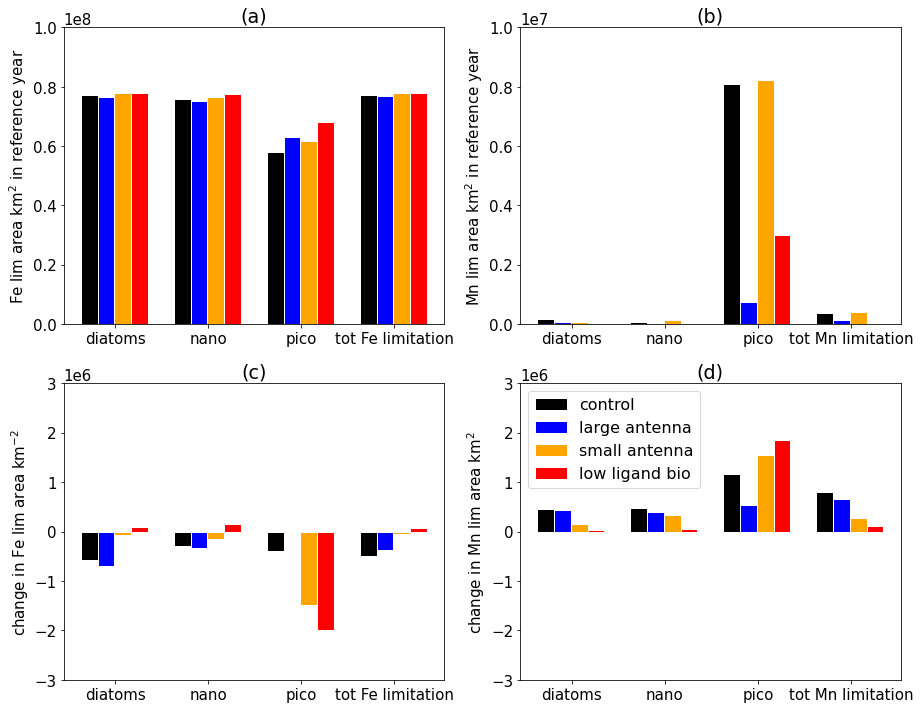

In [8]:

## Plot Figure S1
## This bar chart show the average area over the reference period and the difference 
## between climate change and reference period

barWidth = 0.18
 
# Set position of bar on X axis
r1 = np.arange(len(mdiffs[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

fig1, axs= plt.subplots(2, 2, figsize=(15,12))
fig1.patch.set_facecolor('xkcd:white')
plt.rcParams.update({'font.size': 16})

colors=['#7f6d5f','#557f2d','#2d7f5e']

b=0
a=1
gro=0
mnp=1
fep=0

## manganese area for Reference period
axs[b,mnp].bar(r1, mdiffas[0], width=barWidth, color='black', edgecolor='white', label='control')
axs[b,mnp].bar(r2, mdiffas[1], width=barWidth, color='blue', edgecolor='white', label='large antenna')
axs[b,mnp].bar(r3, mdiffas[2], width=barWidth, color='orange', edgecolor='white', label='small antenna')
axs[b,mnp].bar(r4, mdiffas[3], width=barWidth, color='red', edgecolor='white', label='low ligand bio')

axs[b,mnp].set_xticks([r + (barWidth+0.1) for r in range(len(mdiffs[0]))], ['diatoms', 'nano','pico', 'tot Mn limitation'])

axs[b,mnp].set_ylabel('Mn lim area km$^{2}$ in reference year')
axs[b,mnp].set_ylim(0, 1e7)
axs[b,mnp].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[b,mnp].set_title('(b)')

## iron area for reference period
axs[b,fep].bar(r1, fdiffas[0],  width=barWidth, color='black', edgecolor='white', label='control')
axs[b,fep].bar(r2, fdiffas[1],  width=barWidth, color='blue', edgecolor='white', label='large antenna')
axs[b,fep].bar(r3, fdiffas[2],  width=barWidth, color='orange',edgecolor='white', label='small antenna')
axs[b,fep].bar(r4, fdiffas[3],  width=barWidth, color='red',edgecolor='white', label='low ligand bio')

axs[b,fep].set_xticks([r + (barWidth+0.1) for r in range(len(mdiffs[0]))], ['diatoms', 'nano','pico','tot Fe limitation'])
axs[b,fep].set_ylabel('Fe lim area km$^{2}$ in reference year')
axs[b,fep].set_ylim(0, 1e8)
axs[b,fep].set_title('(a)')

axs[a,mnp].bar(r1, mdiffs[0], width=barWidth, color='black', edgecolor='white', label='control')
axs[a,mnp].bar(r2, mdiffs[1], width=barWidth, color='blue', edgecolor='white', label='large antenna')
axs[a,mnp].bar(r3, mdiffs[2], width=barWidth, color='orange', edgecolor='white', label='small antenna')
axs[a,mnp].bar(r4, mdiffs[3], width=barWidth, color='red', edgecolor='white', label='low ligand bio')

axs[a,mnp].set_xticks([r + (barWidth+0.1) for r in range(len(mdiffs[0]))], [ 'diatoms', 'nano','pico', 'tot Mn limitation'])
axs[a,mnp].set_ylabel('change in Mn lim area km$^{2}$')
axs[a,mnp].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[a,mnp].set_ylim(-3e6,3e6)
axs[a,mnp].set_title('(d)')
axs[a,mnp].legend(loc='best')


axs[a,fep].bar(r1, fdiffs[0],  width=barWidth, color='black', edgecolor='white', label='control')
axs[a,fep].bar(r2, fdiffs[1],  width=barWidth, color='blue', edgecolor='white', label='large antenna')
axs[a,fep].bar(r3, fdiffs[2],  width=barWidth, color='orange',edgecolor='white', label='small antenna')
axs[a,fep].bar(r4, fdiffs[3],  width=barWidth, color='red',  edgecolor='white', label='low ligand bio')

# axs[1].legend(ncol=3, bbox_to_anchor=(0.5, 1.1), loc='upper center')
axs[a,fep].set_xticks([r + (barWidth+0.1) for r in range(len(mdiffs[0]))], [ 'diatoms', 'nano','pico','tot Fe limitation'])
axs[a,fep].set_ylabel('change in Fe lim area km$^{-2}$')
axs[a,fep].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[a,fep].set_ylim(-3e6,3e6)
axs[a,fep].set_title('(c)')

fig1.savefig('area_deficiency.png', dpi=200)